In [4]:
#from tensorflow import keras
#from tensorflow.keras import layers
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

%matplotlib inline

## Preprocessing

In [5]:
df = pd.read_csv('PRSA_data_2010.1.1-2014.12.31.csv')
df

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
43819,43820,2014,12,31,19,8.0,-23,-2.0,1034.0,NW,231.97,0,0
43820,43821,2014,12,31,20,10.0,-22,-3.0,1034.0,NW,237.78,0,0
43821,43822,2014,12,31,21,10.0,-22,-3.0,1034.0,NW,242.70,0,0
43822,43823,2014,12,31,22,8.0,-22,-4.0,1034.0,NW,246.72,0,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43824 entries, 0 to 43823
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   No      43824 non-null  int64  
 1   year    43824 non-null  int64  
 2   month   43824 non-null  int64  
 3   day     43824 non-null  int64  
 4   hour    43824 non-null  int64  
 5   pm2.5   41757 non-null  float64
 6   DEWP    43824 non-null  int64  
 7   TEMP    43824 non-null  float64
 8   PRES    43824 non-null  float64
 9   cbwd    43824 non-null  object 
 10  Iws     43824 non-null  float64
 11  Is      43824 non-null  int64  
 12  Ir      43824 non-null  int64  
dtypes: float64(4), int64(8), object(1)
memory usage: 4.3+ MB


In [7]:
df['pm2.5'].isna().sum()

2067

In [8]:
# drop the rows directly -> mess up the order
# first 24 rows have pm2.5 value that is NaN -> discard
# else: forward filling
df = df[24:].fillna(method='ffill')
df['pm2.5'].isna().sum()

0

In [9]:
import datetime

df['time'] = df.apply(lambda x : datetime.datetime(year=x['year'], month=x['month'], day=x['day'], hour=x['hour']), axis=1)
df.drop(columns=['year', 'month', 'day', 'hour', 'No'], inplace=True)
df = df.set_index('time')
df.head()

,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
time,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


In [10]:
df['cbwd'].unique()

array(['SE', 'cv', 'NW', 'NE'], dtype=object)

In [11]:
df = df.join(pd.get_dummies(df['cbwd'])) # one-hot encoding
del df['cbwd']
df.head()

,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir,NE,NW,SE,cv
time,,,,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,1.79,0,0,0,0,1,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,2.68,0,0,0,0,1,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,3.57,0,0,0,0,1,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,5.36,1,0,0,0,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,6.25,2,0,0,0,1,0


<AxesSubplot:xlabel='time'>

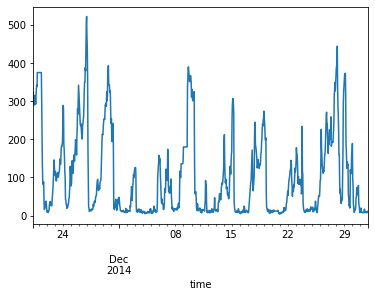

In [12]:
df['pm2.5'][-1000:].plot()

<AxesSubplot:xlabel='time'>

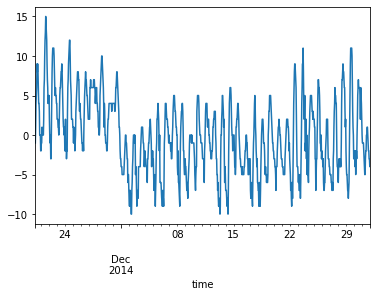

In [13]:
df['TEMP'][-1000:].plot()

## Determine Parameters

In [14]:
seq_len = 5*24 # observe the data for the past 5 days
delay = 1*24 # predict the PM2.5 value one day after

df_ = np.array([df.iloc[i : i + seq_len + delay].values for i in range(len(df) - seq_len - delay)])
df_.shape

(43656, 144, 11)

In [15]:
np.random.shuffle(df_)
x = df_[:, :5*24, :]
y = df_[:, -1, 0]
x.shape, y.shape

((43656, 120, 11), (43656,))

## Split & Normalize the Data

In [16]:
split = int(y.shape[0]*0.8)
train_x = x[:split]
train_y = y[:split]
test_x = x[split:]
test_y = y[split:]

mean = train_x.mean(axis=0)
std = train_x.std(axis=0)
train_x = (train_x - mean) / std
test_x = (test_x - mean) / std # Use the mean & std of train. Since there's no way for us to know the future.

In [17]:
train_x.shape, test_x.shape

((34924, 120, 11), (8732, 120, 11))

## Start by Trying a Simple Model

In [18]:
model = keras.Sequential()
model.add(layers.Flatten(input_shape=(120, 11)))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1)) # Regression -> No Need for Activation

model.summary()

NameError: name 'keras' is not defined

In [16]:
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
history = model.fit(train_x, train_y, batch_size=128, epochs=50, validation_data=(test_x, test_y))

Epoch 1/50
273/273 [==============================] - 1s 4ms/step - loss: 10558.8174 - mae: 73.6832 - val_loss: 8109.5820 - val_mae: 66.6436
Epoch 2/50
273/273 [==============================] - 1s 3ms/step - loss: 7853.4575 - mae: 65.6194 - val_loss: 7290.0532 - val_mae: 63.0301
Epoch 3/50
273/273 [==============================] - 1s 3ms/step - loss: 7174.3193 - mae: 62.4789 - val_loss: 6981.0815 - val_mae: 61.3691
Epoch 4/50
273/273 [==============================] - 1s 3ms/step - loss: 6850.7158 - mae: 60.8652 - val_loss: 6794.8818 - val_mae: 61.0892
Epoch 5/50
273/273 [==============================] - 1s 3ms/step - loss: 6634.7495 - mae: 59.8214 - val_loss: 6664.1519 - val_mae: 60.3337
Epoch 6/50
273/273 [==============================] - 1s 3ms/step - loss: 6463.7451 - mae: 59.0154 - val_loss: 6552.9756 - val_mae: 59.7059
Epoch 7/50
273/273 [==============================] - 1s 3ms/step - loss: 6315.1768 - mae: 58.3521 - val_loss: 6459.2451 - val_mae: 59.3068
Epoch 8/50
273/273 

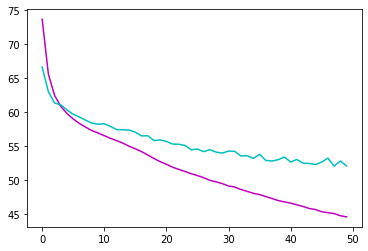

In [17]:
plt.plot(history.epoch, history.history['mae'], c='m')
plt.plot(history.epoch, history.history['val_mae'], c='c')

## Build LSTM Model (Single-Layer)

(34924, 120, 11) -> (batch, time for observation, features per observation)

In [18]:
model = keras.Sequential()
model.add(layers.LSTM(32, input_shape=(120, 11)))
model.add(layers.Dense(1))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 32)                5632      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 5,665
Trainable params: 5,665
Non-trainable params: 0
_________________________________________________________________


In [19]:
model.compile(optimizer='adam', loss='mae')
history = model.fit(train_x, train_y, batch_size=128, epochs=150, validation_data=(test_x, test_y))

Epoch 1/150
273/273 [==============================] - 3s 9ms/step - loss: 88.2862 - val_loss: 80.7078
Epoch 2/150
273/273 [==============================] - 2s 7ms/step - loss: 79.9050 - val_loss: 75.6677
Epoch 3/150
273/273 [==============================] - 2s 8ms/step - loss: 75.7103 - val_loss: 72.0946
Epoch 4/150
273/273 [==============================] - 2s 7ms/step - loss: 72.6449 - val_loss: 69.4177
Epoch 5/150
273/273 [==============================] - 2s 7ms/step - loss: 70.3310 - val_loss: 67.3844
Epoch 6/150
273/273 [==============================] - 2s 7ms/step - loss: 68.5055 - val_loss: 65.7439
Epoch 7/150
273/273 [==============================] - 2s 7ms/step - loss: 66.9308 - val_loss: 64.2163
Epoch 8/150
273/273 [==============================] - 2s 8ms/step - loss: 65.4620 - val_loss: 62.9992
Epoch 9/150
273/273 [==============================] - 2s 7ms/step - loss: 64.2356 - val_loss: 61.9115
Epoch 10/150
273/273 [==============================] - 2s 7ms/step - los

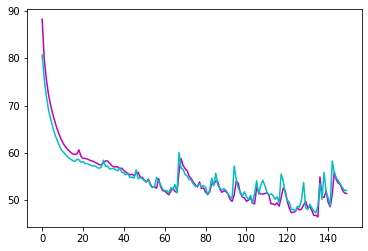

In [20]:
plt.plot(history.epoch, history.history['loss'], c='m')
plt.plot(history.epoch, history.history['val_loss'], c='c')

## Build LSTM Model (Multi-Layer)
Return the state info to feed back to the second LSTM layer

Use callbacks to decrease learning rate

In [21]:
model = keras.Sequential()
model.add(layers.LSTM(32, input_shape=(120, 11), return_sequences=True)) 
model.add(layers.LSTM(32, return_sequences=True)) 
model.add(layers.LSTM(32)) 
model.add(layers.Dense(1))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 120, 32)           5632      
_________________________________________________________________
lstm_2 (LSTM)                (None, 120, 32)           8320      
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 22,305
Trainable params: 22,305
Non-trainable params: 0
_________________________________________________________________


In [22]:
lr_reduced = keras.callbacks.ReduceLROnPlateau('val_loss', patience=3, factor=0.5, min_lr=0.00001)

In [23]:
model.compile(optimizer='adam', loss='mae')
history = model.fit(train_x, train_y, batch_size=128, epochs=150, validation_data=(test_x, test_y), callbacks=[lr_reduced])

Epoch 1/150
273/273 [==============================] - 6s 22ms/step - loss: 88.2528 - val_loss: 81.6525
Epoch 2/150
273/273 [==============================] - 5s 20ms/step - loss: 80.9136 - val_loss: 76.7034
Epoch 3/150
273/273 [==============================] - 5s 18ms/step - loss: 76.7315 - val_loss: 73.1330
Epoch 4/150
273/273 [==============================] - 5s 19ms/step - loss: 73.4562 - val_loss: 70.1019
Epoch 5/150
273/273 [==============================] - 5s 19ms/step - loss: 70.9368 - val_loss: 67.9677
Epoch 6/150
273/273 [==============================] - 6s 21ms/step - loss: 69.1322 - val_loss: 66.4841
Epoch 7/150
273/273 [==============================] - 5s 18ms/step - loss: 67.8715 - val_loss: 65.4718
Epoch 8/150
273/273 [==============================] - 6s 23ms/step - loss: 67.0046 - val_loss: 64.7755
Epoch 9/150
273/273 [==============================] - 5s 18ms/step - loss: 66.4133 - val_loss: 64.3161
Epoch 10/150
273/273 [==============================] - 5s 18ms/

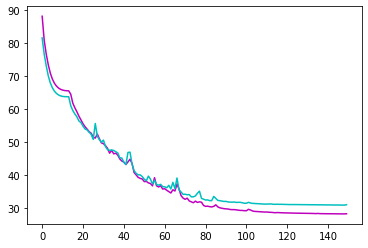

In [24]:
plt.plot(history.epoch, history.history['loss'], c='m')
plt.plot(history.epoch, history.history['val_loss'], c='c')

## Evaluation & Prediction

In [25]:
model.evaluate(test_x, test_y, verbose=0)

30.936580657958984

In [26]:
test_predict = model.predict(test_x)
test_x.shape, test_predict.shape

((8732, 120, 11), (8732, 1))

In [27]:
test_predict[:5]

array([[198.89764 ],
       [ 28.539043],
       [244.49496 ],
       [241.20007 ],
       [ 89.95556 ]], dtype=float32)

In [28]:
test_data = df[-120:]
test_data = (test_data - mean)/std
test_data

,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir,NE,NW,SE,cv
time,,,,,,,,,,,
2014-12-27 00:00:00,0.713524,-0.822246,-1.430934,1.321080,-0.442079,-0.070268,-0.138822,-0.358941,1.446370,-0.731151,-0.521935
2014-12-27 01:00:00,1.054271,-0.822400,-1.431359,1.320566,-0.405952,-0.070224,-0.139121,-0.358229,1.441558,-0.728662,-0.522690
2014-12-27 02:00:00,0.978673,-0.822067,-1.430926,1.320543,-0.370990,-0.070157,-0.138782,-0.360362,1.446087,-0.729952,-0.521713
2014-12-27 03:00:00,1.297398,-0.891797,-1.512640,1.320438,-0.334711,-0.070439,-0.138617,-0.357465,1.441840,-0.730136,-0.522068
2014-12-27 04:00:00,1.399654,-0.891403,-1.513229,1.320578,-0.298866,-0.070623,-0.138280,-0.357618,1.443253,-0.729583,-0.523134
...,...,...,...,...,...,...,...,...,...,...,...
2014-12-31 19:00:00,-0.983081,-1.725566,-1.190462,1.710678,4.168464,-0.069012,-0.137181,-0.358127,1.447981,-0.730874,-0.523666
2014-12-31 20:00:00,-0.961436,-1.656596,-1.272333,1.711026,4.273864,-0.068723,-0.137229,-0.358330,1.449689,-0.732350,-0.522867
2014-12-31 21:00:00,-0.962722,-1.657413,-1.272223,1.710975,4.384778,-0.068988,-0.137587,-0.357669,1.451115,-0.730229,-0.526151


In [29]:
test_data = np.expand_dims(test_data, axis=0)
test_data.shape

(1, 120, 11)

In [30]:
model.predict(test_data) # 2015.1.1 11pm pM2.5

array([[19.552254]], dtype=float32)